In [1]:
%env RANK=0
%env WORLD_SIZE=1
%env MASTER_ADDR=127.0.0.1
%env MASTER_PORT=2020

env: RANK=0
env: WORLD_SIZE=1
env: MASTER_ADDR=127.0.0.1
env: MASTER_PORT=2020


In [2]:
llama_checkpoint_dir = "modified_llama/llama-2-7b"
tokenizer_path = "modified_llama/tokenizer.model"
compression_checkpoint_dir = "cv_library/attention_model.pt"
tfidf_file = "tfidf.json"
cv_dir_path = "db/"
max_seq_len = 256
max_batch_size = 1

In [3]:
import json
import torch

# Load TFIDF scores
with open(tfidf_file, 'r') as file:
    tfidf_buffer = json.load(file)

tfidfs = {
    document_id: torch.tensor(tfidf)
    for document_id, tfidf in tfidf_buffer.items()
}

In [4]:
import os
import pickle

# Get some context vectors
cv_tfidf_collection = {}
key_pairs = set()
for filename in os.listdir(cv_dir_path):
    filepath = f"{cv_dir_path}/{filename}"
    with open(filepath, 'rb') as file:
        doc = pickle.load(file)

    article_title = doc["title"]
    section_cv_map = doc["section_cv_map"]
    cv_tfidf_collection[article_title] = {}
    for section, context_vector in section_cv_map.items():
        tfidf_key = f"{article_title}\\{section}"
        if tfidf_key not in tfidfs:
            continue
        tfidf = tfidfs[tfidf_key]

        # Forget tfidfs that are all 0
        if (tfidf > 0.0).any():
            cv_tfidf_collection[article_title][section] = (context_vector, tfidf)
            key_pairs.add((article_title, section))

In [5]:
import random

# Shuffle key pairs
key_pairs = list(key_pairs)
random.shuffle(key_pairs)

In [6]:
# Find doc with most sections
article_lengths = [(title, len(sections)) for title, sections in cv_tfidf_collection.items()]
article_lengths = sorted(article_lengths, key=lambda k: k[1], reverse=True)
keep_articles = set(name for name, _ in article_lengths[:100])

# Drop articles we don't want to keep
drop_articles = set(title for title in cv_tfidf_collection if title not in keep_articles)
for title in drop_articles:
    del cv_tfidf_collection[title]

In [7]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [8]:
from cv_library.hierarchical_compression import HierarchicalAttention
from cv_library.loss_functions import sequence_similarity
from pathlib import Path
import torch.nn.functional as F

# Load the compression network
torch.set_default_dtype(torch.float32)
with torch.device("cuda:0"):
    compression_network = HierarchicalAttention([256, 4096])
    checkpoint_path = Path(compression_checkpoint_dir)
    if checkpoint_path.is_file():
        checkpoint = torch.load(checkpoint_path, map_location="cuda:0")
        compression_network.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("ERROR: Path provided for hierarchical compression model not a file")
        exit(1)


Layer #1 output size: 512
Layer #2 output size: 64
Layer #3 output size: 8


/tmp/ipykernel_3397689/1679737792.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="cuda:0")


In [9]:
graph_xs = []
graph_ys = []
for title, section_cv_map in cv_tfidf_collection.items():
    cv_tfidf_list = list(section_cv_map.values())
    for i in range(len(cv_tfidf_list)):
        content_cv, content_tfidf = cv_tfidf_list[i]
        if len(content_cv) < 256:
            continue
        compressed_content = compression_network.forward(content_cv.unsqueeze(0).to(torch.float32))
        for j in range(i + 1, len(cv_tfidf_list)):
            query_cv, query_tfidf = cv_tfidf_list[j]
            if len(query_cv) < 256:
                continue
            compressed_query = compression_network.forward(query_cv.unsqueeze(0).to(torch.float32))

            tfidf_cos_sim = torch.dot(
                F.normalize(content_tfidf, dim=-1),
                F.normalize(query_tfidf, dim=-1)
            )
            graph_xs.append(tfidf_cos_sim.item())

            for level, (cc, cq) in enumerate(zip(compressed_content, compressed_query)):
                sim_score = sequence_similarity(cc, cq).item()
                while level >= len(graph_ys):
                    graph_ys.append([])
                graph_ys[level].append(sim_score)

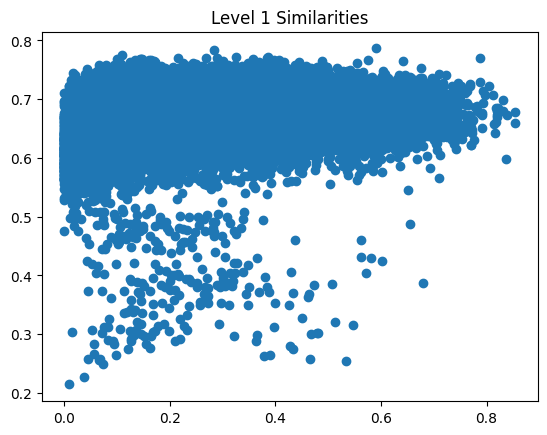

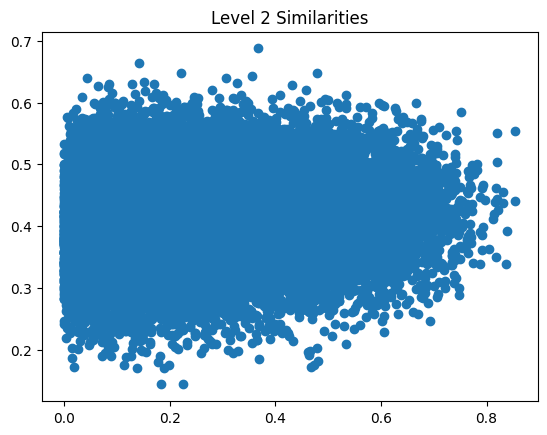

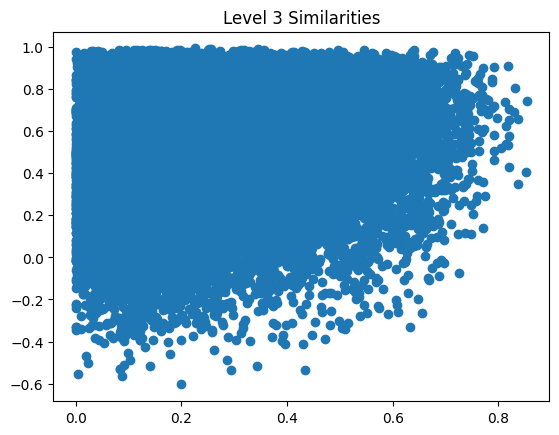

In [10]:
import matplotlib.pyplot as plt

for level, ys in enumerate(graph_ys):
    plt.figure(level)
    plt.title(f"Level {level + 1} Similarities")
    plt.scatter(graph_xs, ys)